# TSNE  Visualization of Average Word to Vector For Amazon Fine Food Reviews

This Dataset conists of reviews of fine foods from amazon.
which includes:
- Reviews from Oct 1999 - Oct 2012
- Total of 568,454 reviews
- Given by 256,059 users
- For 74,258 products

# Data Cleaning and Loading

The same data is cleaned, by removing the duplicates and the reviews for which HelpfulnessNumerator is greater than HelpfulnessDenominator. So it is reduced to 364171 reviews with same 10 columns. This data with 364171 reviews is stored in a SQLite Database named 'final_sqlite' and the table for these reviews is 'Reviews'.

We load the data using SQLite in to pandas dataframe

In [1]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect('final_sqlite')
data = pd.read_sql_query('''select * from Reviews''', conn)
print(data.shape)
print(data.columns)

(364171, 12)
Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'ClearedText'],
      dtype='object')


In [2]:
def convert(x):
    '''To convert the reviews to positive or negative'''
    return 'Negative' if x<3 else 'Positive'
score = data['Score'].map(convert)
print(score.shape)

(364171,)


Here we determine a review as Positive or Negative by using the score. If score is more than 3 then it is considered as a positive and negative if it is less than 3 and will ignore if score is 3, as we can't decide whether it will fall into positive or negative category. The data which is in the Reviews table is queried/ saved without the reviews with score 3.

In [3]:
import re
def cleanhtml(sentence): 
    '''To clean html-tags in the sentense'''
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    '''To clean punctuation or special characters in the sentense'''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [5]:
list_of_sent=[]
for sent in data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [6]:
print(data['Text'].values[6])
print("*****************************************************************")
print(list_of_sent[6])

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
*****************************************************************
['i', 'set', 'aside', 'at', 'least', 'an', 'hour', 'each', 'day', 'to', 'read', 'to', 'my', 'son', 'y', 'o', 'at', 'this', 'point', 'i', 'consider', 'myself', 'a', 'connoisseur', 'of', 'childrens', 'books', 'and', 'this', 'is', 'one', 'of', 'the', 'best', 'santa', 'clause', 'put', 'this', 'under', 'the', 'tree', 'since', 'then', 'weve', 'read', 'it', 'perpetually'

# Average Word to Vector

In [7]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

D:\Users\KiranPS\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
words = list(w2v_model.wv.vocab)
print(len(words))

33783


In [9]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

D:\Users\KiranPS\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


364171
50


In [12]:
df= pd.DataFrame(sent_vectors)
df.fillna(-99999, inplace = True)


In [15]:
from sklearn.preprocessing import StandardScaler
df = StandardScaler(with_mean=False).fit_transform(df)
print(df.shape)

(364171, 50)


In [16]:
f_1k = df[0:1000]
s_1k = score[0:1000]
print(f_1k.shape)
print(s_1k.shape)

(1000, 50)
(1000,)


# TSNE Visualization of Avg W2V

In [17]:
from sklearn.manifold import TSNE
model = TSNE(n_components =2, random_state = 0)
tsne_data = model.fit_transform(f_1k)
print(tsne_data.shape)

(1000, 2)


We choose 1000 records to visualize data using TSNE

In [18]:
import numpy as np
c_data = np.vstack((tsne_data.T, s_1k)).T
frame = pd.DataFrame(c_data, columns =( 'vector1', 'vector2', 'label'))
print(frame.shape)

(1000, 3)


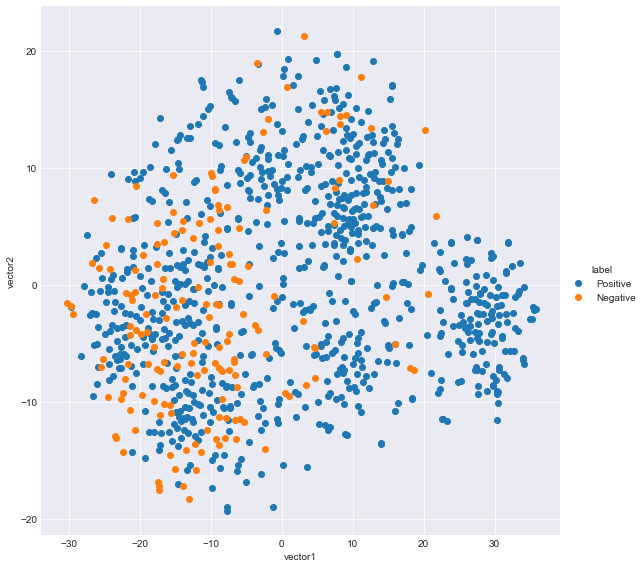

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.FacetGrid(frame, hue = 'label', size =8).map(plt.scatter,'vector1', 'vector2').add_legend()
plt.show()

In [21]:
f_2k = df[0:2000]
s_2k = score[0:2000]
print(f_2k.shape)
print(s_2k.shape)

(2000, 50)
(2000,)


We choose 2000 records to visualize data using TSNE

In [22]:
model = TSNE(n_components =2, random_state = 0)
tsne_data = model.fit_transform(f_2k)
print(tsne_data.shape)

(2000, 2)


In [23]:
c_data = np.vstack((tsne_data.T, s_2k)).T
frame = pd.DataFrame(c_data, columns =( 'vector1', 'vector2', 'label'))
print(frame.shape)

(2000, 3)


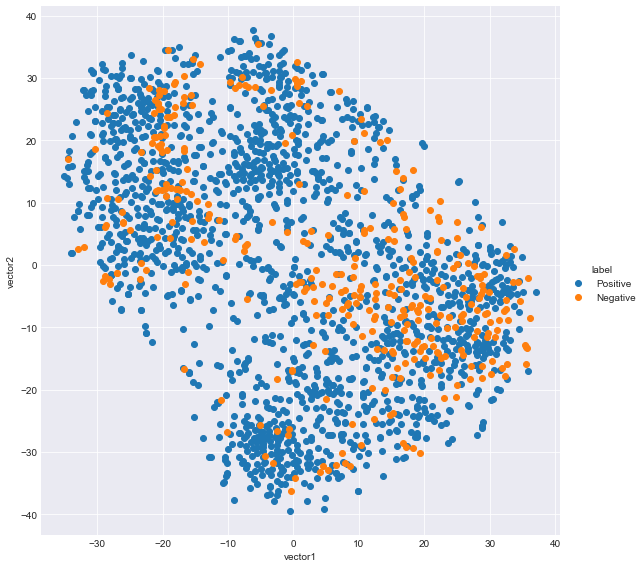

In [24]:
sns.set_style('darkgrid')
sns.FacetGrid(frame, hue = 'label', size =8).map(plt.scatter,'vector1', 'vector2').add_legend()
plt.show()

We choose 10000 records to visualize data using TSNE

In [27]:
f_10k = df[0:10000]
s_10k = score[0:10000]
print(f_10k.shape)
print(s_10k.shape)

(10000, 50)
(10000,)


In [28]:
model = TSNE(n_components =2, random_state = 0)
tsne_data = model.fit_transform(f_10k)
print(tsne_data.shape)

(10000, 2)


In [29]:
c_data = np.vstack((tsne_data.T, s_10k)).T
frame = pd.DataFrame(c_data, columns =( 'vector1', 'vector2', 'label'))
print(frame.shape)

(10000, 3)


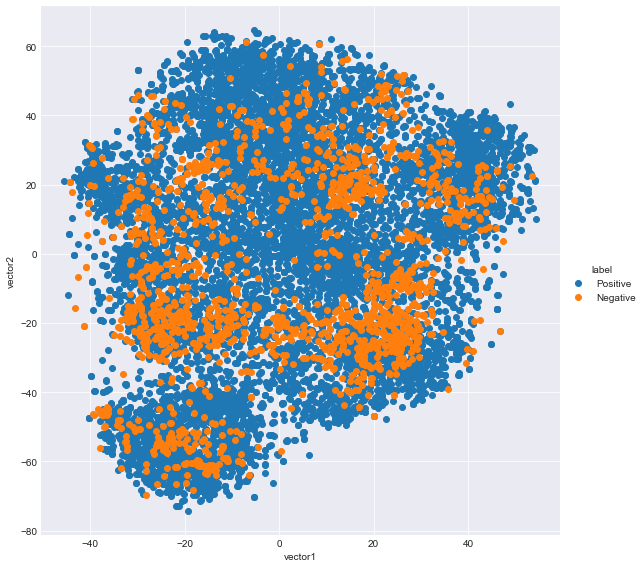

In [30]:
sns.set_style('darkgrid')
sns.FacetGrid(frame, hue = 'label', size =8).map(plt.scatter,'vector1', 'vector2').add_legend()
plt.show()

We choose whole of 364171 records to visualize data using TSNE

In [31]:
 model = TSNE(n_components =2, random_state = 0)
tsne_data = model.fit_transform(df)
print(tsne_data.shape)

(364171, 2)


In [32]:
c_data = np.vstack((tsne_data.T, score)).T
frame = pd.DataFrame(c_data, columns =( 'vector1', 'vector2', 'label'))
print(frame.shape)

(364171, 3)


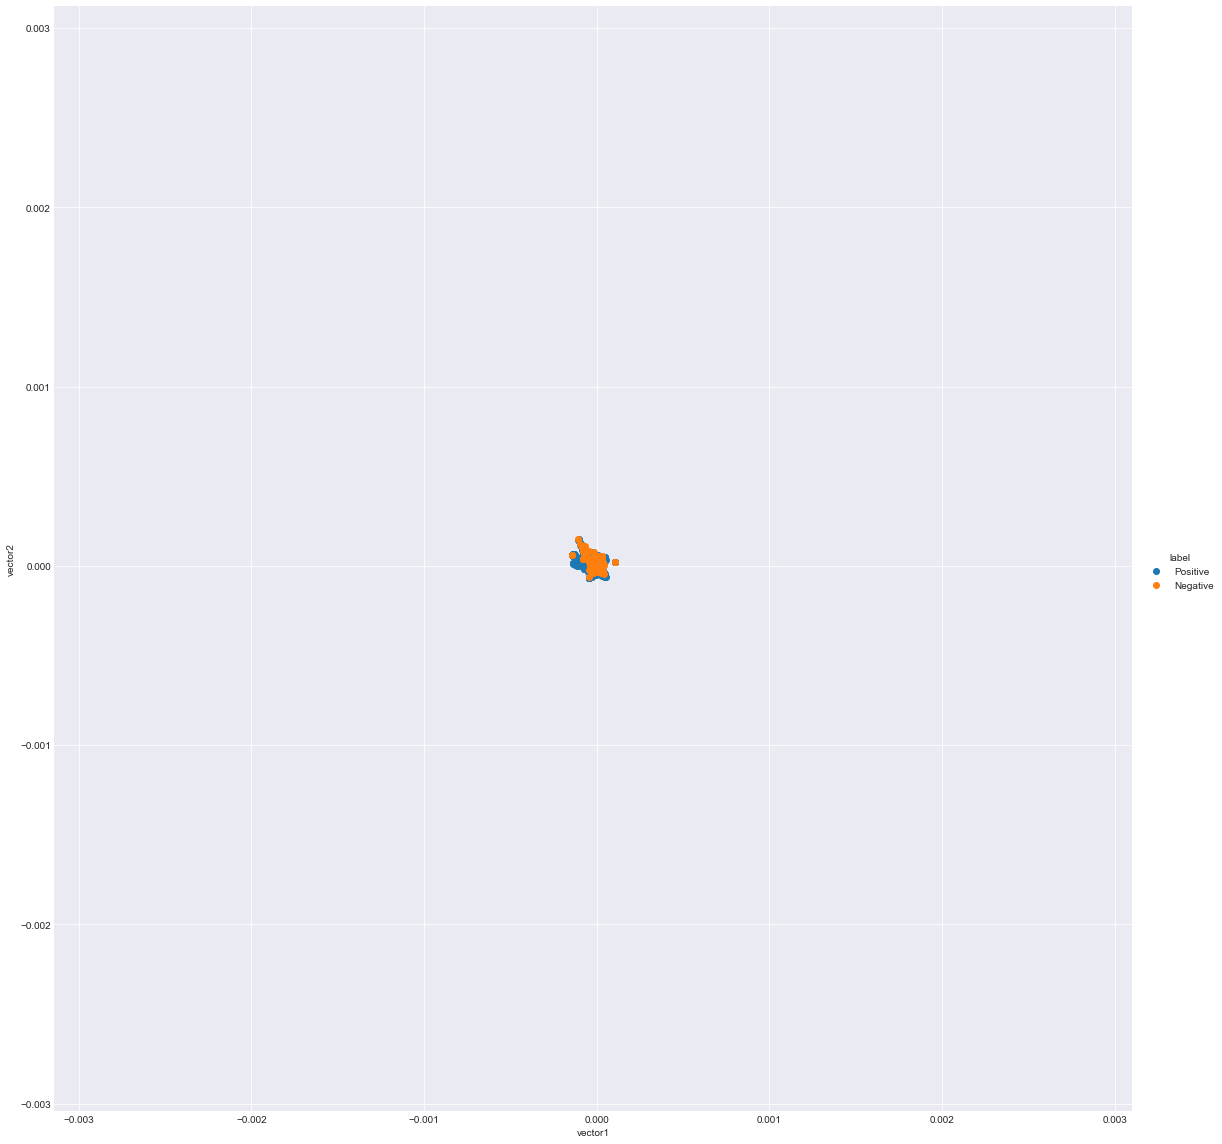

In [33]:
sns.set_style('darkgrid')
sns.FacetGrid(frame, hue = 'label', size =16).map(plt.scatter,'vector1', 'vector2').add_legend()
plt.show()

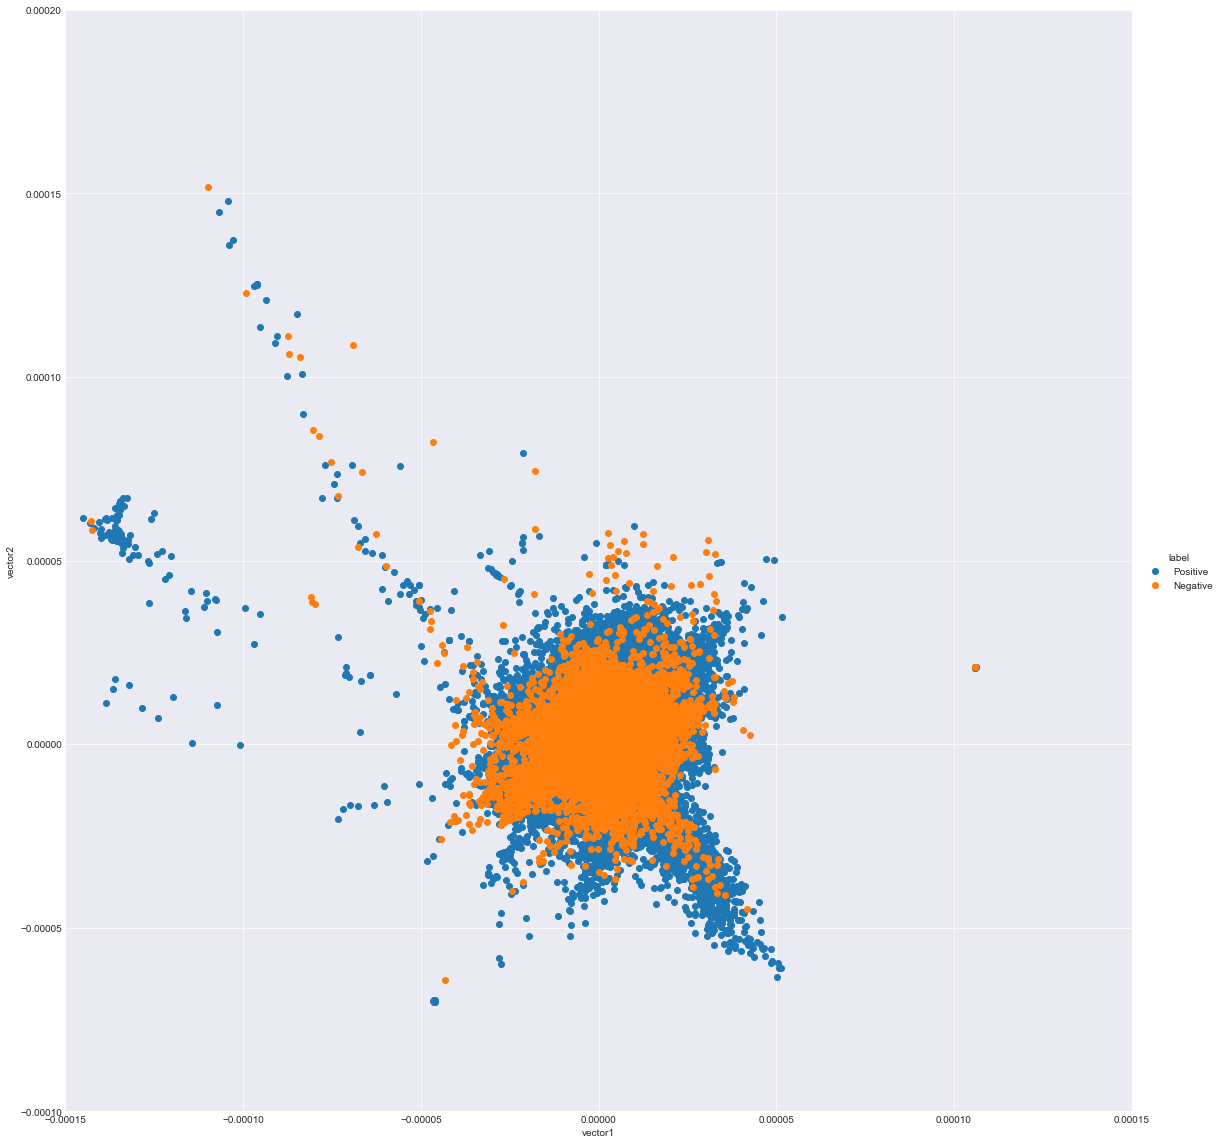

In [34]:
sns.set_style('darkgrid')
sns.FacetGrid(frame, hue = 'label', size =16,ylim= (-0.0001,0.0002),xlim= (-0.00015,0.00015)).map(plt.scatter,'vector1', 'vector2').add_legend()
plt.show()

# Observations:
Even these doesnot give much difference and we cannot bifercate or differentiate whether a review is positive or negative. Both the reviews are spread accross the graph. So we will proceed with other approach and check whether they can be bifercated.